# EDA Crashes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from raw_to_transformed_data import get_sql_data
from plotting_functions import injury_vs_no_injury_plot, rewrite_yaxis_labels, save_plot

pd.set_option("display.max_columns", None)
plt.style.use("ggplot")
%matplotlib inline

In [2]:
query_crashes = """
    SELECT *
    FROM crashes;
    """
dbname = "chi-traffic-accidents"

In [3]:
df_crashes = get_sql_data(dbname, query_crashes)

In [4]:
df_crashes["has_injuries"] = np.where(df_crashes["injuries_total"]==0, False, True)

**Need to convert to category for order**

In [5]:
df_crashes["crash_day_of_week"] = pd.Categorical(
    df_crashes["crash_day_of_week"],
    categories=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", 
        "Friday", "Saturday"],
    ordered=True)
df_crashes["crash_month"] = pd.Categorical(
    df_crashes["crash_month"],
    categories=['January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'],
    ordered=True)

# raw_cat = pd.Categorical(
#    ....:     ["a", "b", "c", "a"], categories=["b", "c", "d"], ordered=False
#    ....: )

**Add category for number of injuries for EDA**

In [6]:
df_crashes["injury_category"] = np.select(
    [df_crashes["injuries_total"] == 0, 
        df_crashes["injuries_total"] == 1,
        df_crashes["injuries_total"] == 2,
        df_crashes["injuries_total"] > 2,],
    ["0 Injuries", "1 Injury", "2 Injuries", "3+ Injuries"],
    default="0")
df_crashes["injury_category"] = pd.Categorical(
    df_crashes["injury_category"],
    categories=["0 Injuries", "1 Injury", "2 Injuries", "3+ Injuries"],
    ordered=True)

In [7]:
df_crashes.head()

,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,report_type,prim_contributory_cause,street_direction,num_units,injuries_total,crash_hour,crash_day_of_week,crash_month,intersection_related_i,hit_and_run_i,lane_cnt,has_injuries,injury_category
0,7a63945a9bae12c05dee82c1962bf40f23cdd02ca655d7...,2021-08-01 03:42:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,UNKNOWN,ON SCENE,DISREGARDING OTHER TRAFFIC SIGNS,S,2,0.0,3,Sunday,August,None,None,NaN,False,0 Injuries
1,d207ce72f4348fa06dddcd98628d0dec81d4f195cb8d8b...,2021-08-01 02:41:00,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),DISREGARDING TRAFFIC SIGNALS,N,2,1.0,2,Sunday,August,Y,Y,NaN,True,1 Injury
2,bba4db7cfef29230aa5d24f6b8912a2539b5d6f481a94e...,2021-08-01 02:26:00,25,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,UNKNOWN,ON SCENE,IMPROPER TURNING/NO SIGNAL,S,2,0.0,2,Sunday,August,None,None,NaN,False,0 Injuries
3,1e39110c6e01fd2f24e282cd610eb90d6f98a6241ab193...,2021-08-01 02:22:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,OTHER,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,UNABLE TO DETERMINE,S,2,1.0,2,Sunday,August,N,Y,NaN,True,1 Injury
4,d20d9db8a88fc227d48392b45380ae57898e5fcdcda7db...,2021-08-01 02:08:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DUSK,PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,IMPROPER LANE USAGE,W,3,2.0,2,Sunday,August,None,Y,NaN,True,2 Injuries


## Number of crashes with injuries

In [8]:
df_crashes.shape

(526569, 25)

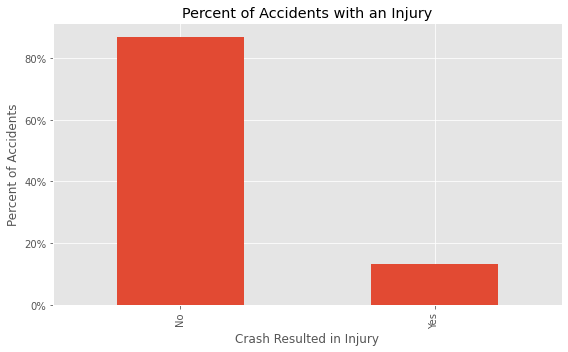

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
(df_crashes["has_injuries"]
     .value_counts(dropna=False, normalize=True)
     .plot(kind="bar", ax=ax))
ax.set_title("Percent of Accidents with an Injury")
ax.set_xlabel("Crash Resulted in Injury")
ax.set_ylabel("Percent of Accidents")
ax.set_xticklabels(["No", "Yes"])
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.8, num_points=5)
save_plot("percent-accidents-with-injuries");

In [10]:
np.round(df_crashes["has_injuries"].value_counts(dropna=False, normalize=True)*100, 0)

False    87.0
True     13.0
Name: has_injuries, dtype: float64

Crashes with injuries

In [11]:
(df_crashes
    .loc[df_crashes["has_injuries"]==True, "injuries_total"]
    .value_counts(dropna=False, normalize=True)).index.values.astype(int)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 15, 11, 12, 13, 21, 19, 16])

In [12]:
perc_num_accidents = (df_crashes
    .loc[df_crashes["has_injuries"]==True, "injuries_total"]
    .value_counts(dropna=False, normalize=True))
perc_num_accidents = perc_num_accidents.reindex(
    index=perc_num_accidents.index.values.astype(int))
perc_num_accidents = perc_num_accidents.sort_index()
perc_num_accidents

1     0.755296
2     0.165080
3     0.050273
4     0.018063
5     0.006703
6     0.002626
7     0.000987
8     0.000348
9     0.000232
10    0.000131
11    0.000073
12    0.000029
13    0.000029
15    0.000073
16    0.000015
19    0.000015
21    0.000029
Name: injuries_total, dtype: float64

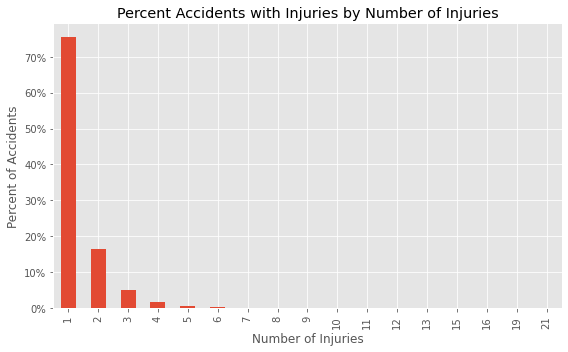

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
perc_num_accidents.plot(kind="bar", ax=ax)
ax.set_title("Percent Accidents with Injuries by Number of Injuries")
ax.set_xlabel("Number of Injuries")
ax.set_ylabel("Percent of Accidents")
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.7, num_points=8)
save_plot("percent-accidents-with-injuries-by-number-injuries");

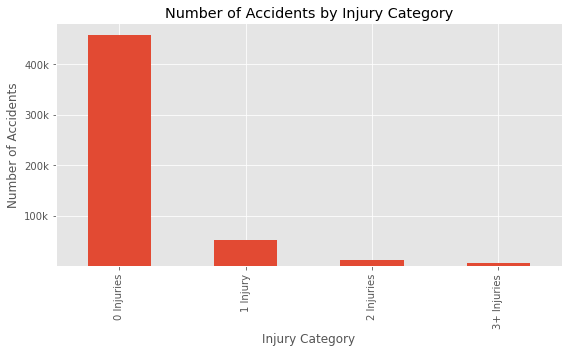

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
df_crashes["injury_category"].value_counts().plot(kind="bar")
ax.set_title("Number of Accidents by Injury Category")
ax.set_xlabel("Injury Category")
ax.set_ylabel("Number of Accidents")
fig, ax = rewrite_yaxis_labels(fig, ax, percent=False, start=100_000, stop=400_000, step=100_000)
save_plot("num-accidents-by-injury-category");

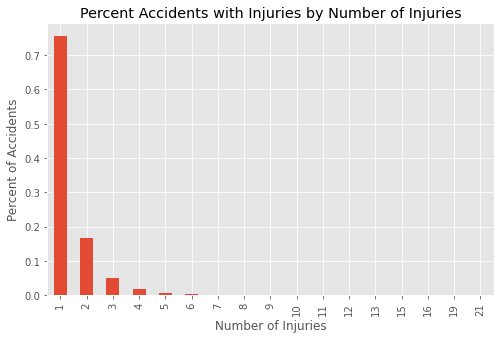

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
perc_num_accidents.plot(kind="bar", ax=ax)
ax.set_title("Percent Accidents with Injuries by Number of Injuries")
ax.set_xlabel("Number of Injuries")
ax.set_ylabel("Percent of Accidents");

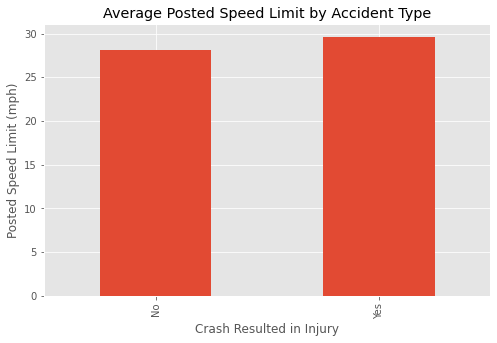

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
(df_crashes
    .groupby("has_injuries")["posted_speed_limit"]
    .mean().plot(kind="bar", ax=ax))
ax.set_title("Average Posted Speed Limit by Accident Type")
ax.set_xlabel("Crash Resulted in Injury")
ax.set_ylabel("Posted Speed Limit (mph)")
ax.set_xticklabels(["No", "Yes"])
save_plot("average-posted-speed-limit-accident-type");

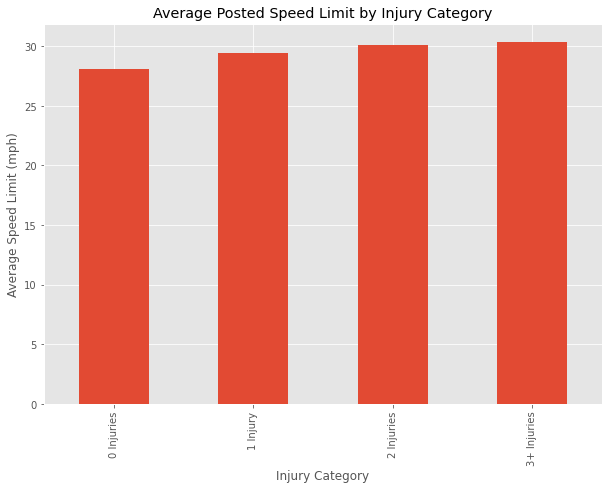

In [69]:
fig, ax = plt.subplots(figsize=(10, 7))

df_crashes.groupby("injury_category")["posted_speed_limit"].mean().plot(kind="bar", ax=ax)

ax.set_title("Average Posted Speed Limit by Injury Category")
ax.set_xlabel("Injury Category")
ax.set_ylabel("Average Speed Limit (mph)")
save_plot("average-posted-speed-limit-accident-type");

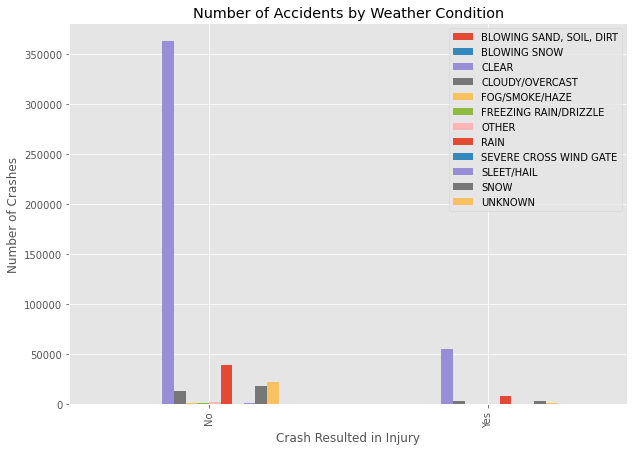

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
(df_crashes
    .groupby(["has_injuries", "weather_condition"])["crash_record_id"]
    .count()
    .reset_index()
    .set_index("has_injuries")
    .pivot(columns="weather_condition", values="crash_record_id")
    .fillna(0.0)).plot(kind="bar", ax=ax)
ax.set_title("Number of Accidents by Weather Condition")
ax.set_xlabel("Crash Resulted in Injury")
ax.set_ylabel("Number of Crashes")
ax.legend(title=None)
ax.set_xticklabels(["No", "Yes"]);

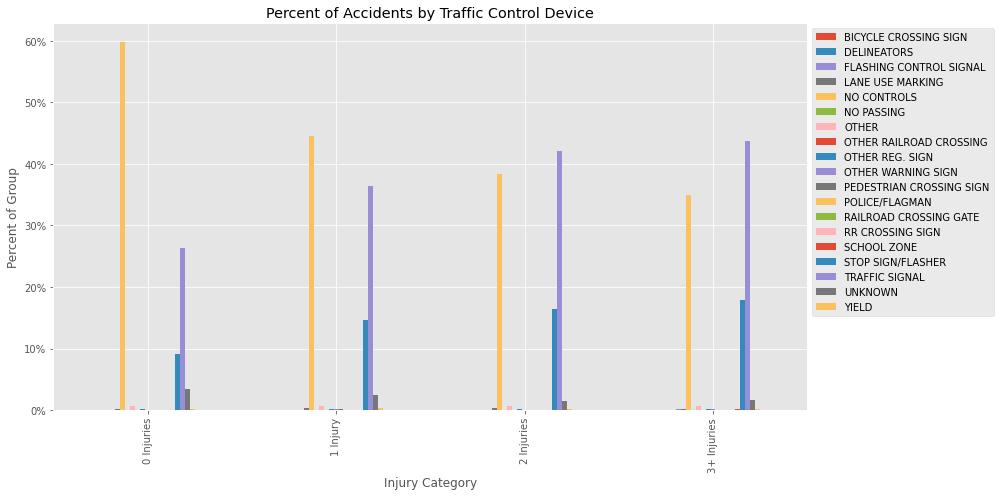

In [18]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "traffic_control_device", 
    base_feature="injury_category",
    figsize=(14, 7),
    title="Percent of Accidents by Traffic Control Device",
    xlabel="Injury Category",
    ylabel="Percent of Group",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.6, num_points=7)
save_plot("percent-accidents-by-traffic-control-device");

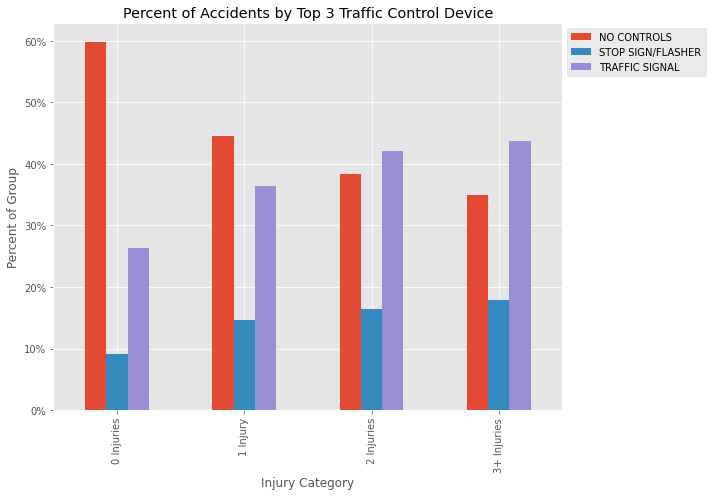

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
perc = (
    (df_crashes.groupby(["injury_category", "traffic_control_device"])["crash_record_id"]
        .count()) 
    / (df_crashes.groupby(["injury_category"])["crash_record_id"].count()))
perc = (perc.reset_index()
    .set_index("injury_category")
    .pivot(columns="traffic_control_device", values="crash_record_id")
    .fillna(0.0))
perc.loc[:, (perc > 0.05).all().values].plot(kind="bar", ax=ax)
ax.set_title("Percent of Accidents by Top 3 Traffic Control Device")
ax.set_xlabel("Injury Category")
ax.set_ylabel("Percent of Group")
ax.legend(title=None, loc="upper left", bbox_to_anchor=(1, 1))
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.6, num_points=7)
save_plot("percent-accidents-by-traffic-control-device-top-3");

In [20]:
print(type(fig))

<class 'matplotlib.figure.Figure'>


In [21]:
print(type(ax))

<class 'matplotlib.axes._subplots.AxesSubplot'>


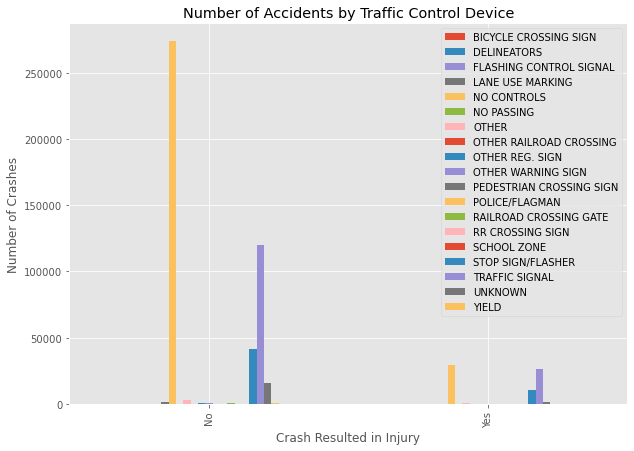

In [22]:
injury_vs_no_injury_plot(
    df_crashes, "traffic_control_device", 
    title="Number of Accidents by Traffic Control Device",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

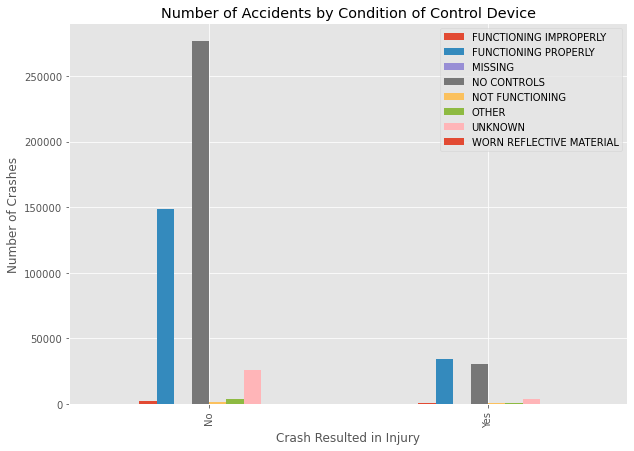

In [23]:
injury_vs_no_injury_plot(
    df_crashes, "device_condition", 
    title="Number of Accidents by Condition of Control Device",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

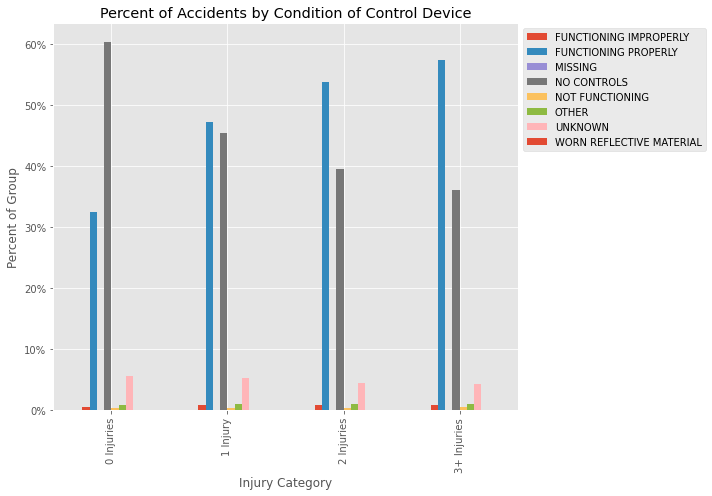

In [24]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "device_condition", 
    base_feature="injury_category",
    figsize=(10, 7),
    title="Percent of Accidents by Condition of Control Device",
    xlabel="Injury Category",
    ylabel="Percent of Group",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.6, num_points=7)
save_plot("percent-accidents-by-control-device-condition");

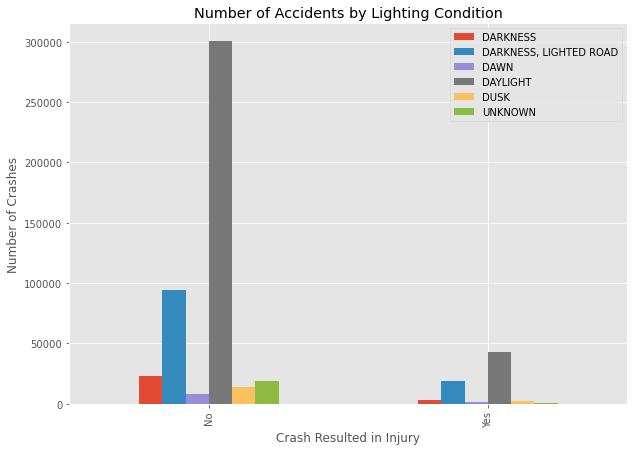

In [25]:
injury_vs_no_injury_plot(
    df_crashes, "lighting_condition", 
    title="Number of Accidents by Lighting Condition",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

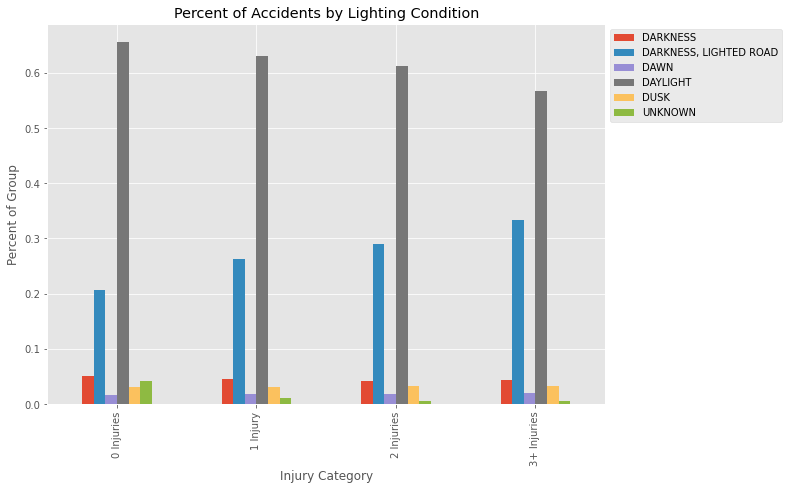

In [26]:
injury_vs_no_injury_plot(
    df_crashes, "lighting_condition", 
    base_feature="injury_category",
    figsize=(10, 7),
    title="Percent of Accidents by Lighting Condition",
    xlabel="Injury Category",
    ylabel="Percent of Group",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.6, num_points=7)
save_plot("percent-accidents-by-lighting-condition");

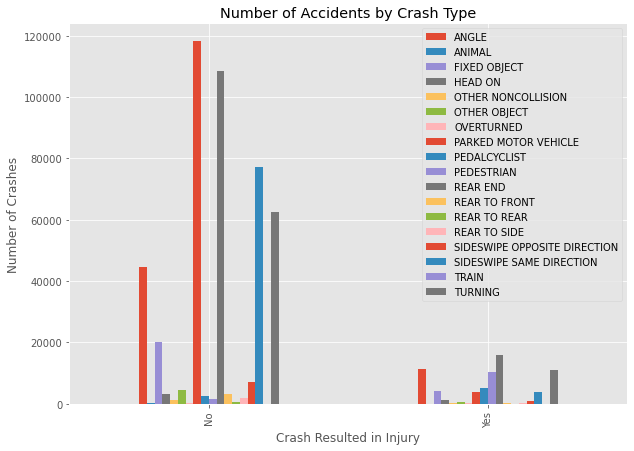

In [27]:
injury_vs_no_injury_plot(
    df_crashes, "first_crash_type", 
    title="Number of Accidents by Crash Type",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

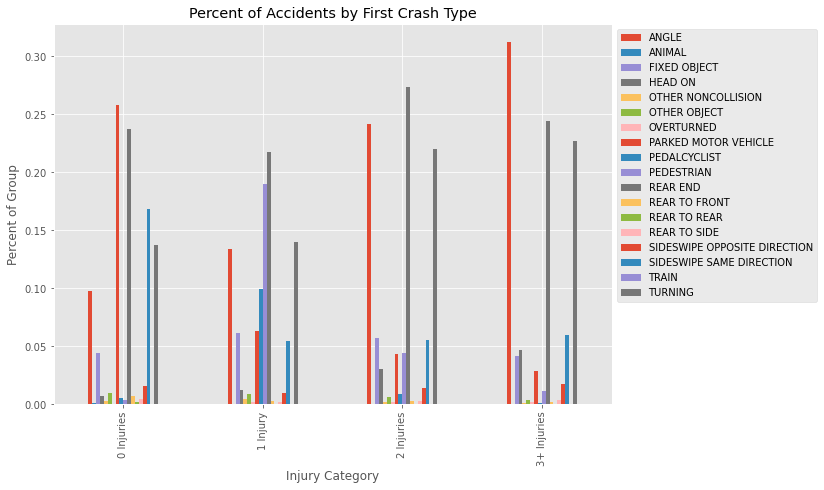

In [28]:
injury_vs_no_injury_plot(
    df_crashes, "first_crash_type", 
    base_feature="injury_category",
    title="Percent of Accidents by First Crash Type",
    xlabel="Injury Category",
    ylabel="Percent of Group",
    percents=True);

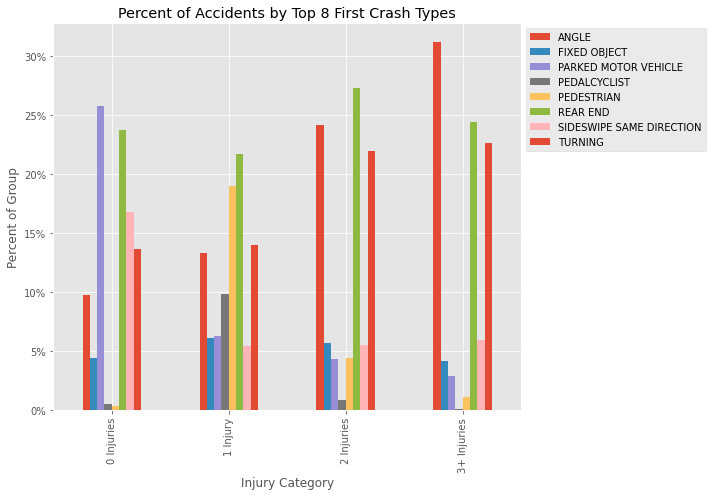

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
perc = (
    (df_crashes.groupby(["injury_category", "first_crash_type"])["crash_record_id"]
        .count()) 
    / (df_crashes.groupby(["injury_category"])["crash_record_id"].count()))
perc = (perc.reset_index()
    .set_index("injury_category")
    .pivot(columns="first_crash_type", values="crash_record_id")
    .fillna(0.0))
perc.loc[:, (perc > 0.05).any().values].plot(kind="bar", ax=ax)
ax.set_title("Percent of Accidents by Top 8 First Crash Types")
ax.set_xlabel("Injury Category")
ax.set_ylabel("Percent of Group")
ax.legend(title=None, loc="upper left", bbox_to_anchor=(1, 1))
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.30, num_points=7)
save_plot("percent-accidents-by-crash-type-top-8");

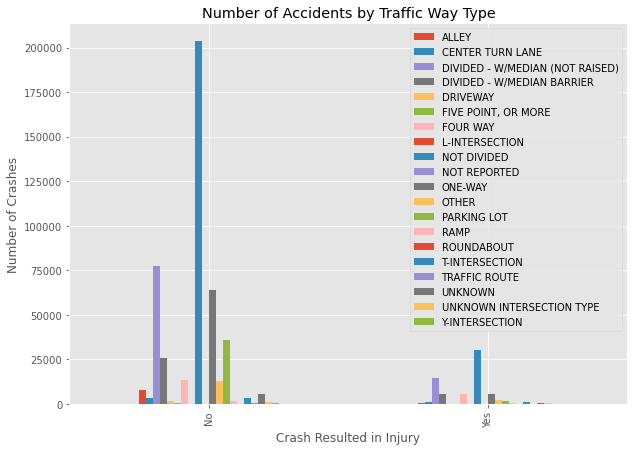

In [30]:
injury_vs_no_injury_plot(
    df_crashes, "trafficway_type", 
    title="Number of Accidents by Traffic Way Type",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

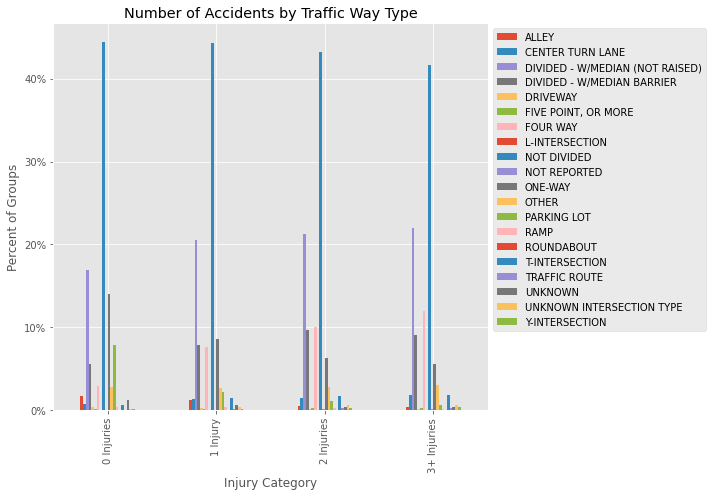

In [56]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "trafficway_type",
    base_feature="injury_category",
    title="Number of Accidents by Traffic Way Type",
    xlabel="Injury Category",
    ylabel="Percent of Groups",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.4, num_points=5)
save_plot("percent-accidents-by-traffic-way-type");

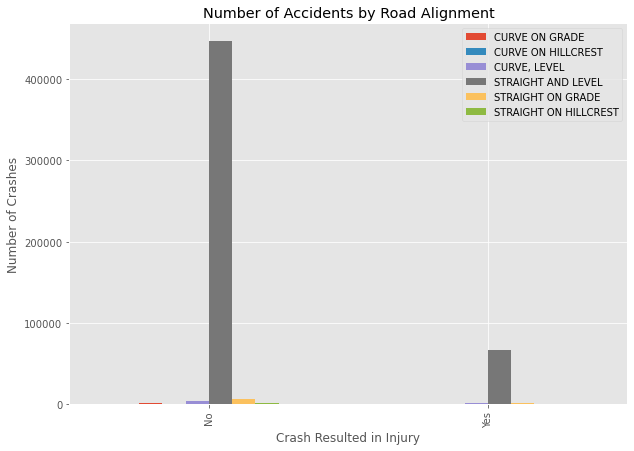

In [32]:
injury_vs_no_injury_plot(
    df_crashes, "alignment", 
    title="Number of Accidents by Road Alignment",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

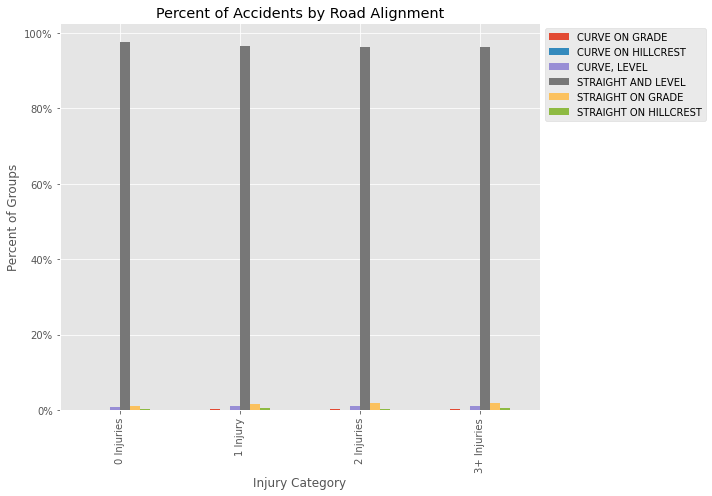

In [57]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "alignment",
    base_feature="injury_category",
    title="Percent of Accidents by Road Alignment",
    xlabel="Injury Category",
    ylabel="Percent of Groups",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=1.0, num_points=6)
save_plot("percent-accidents-road-alignment")

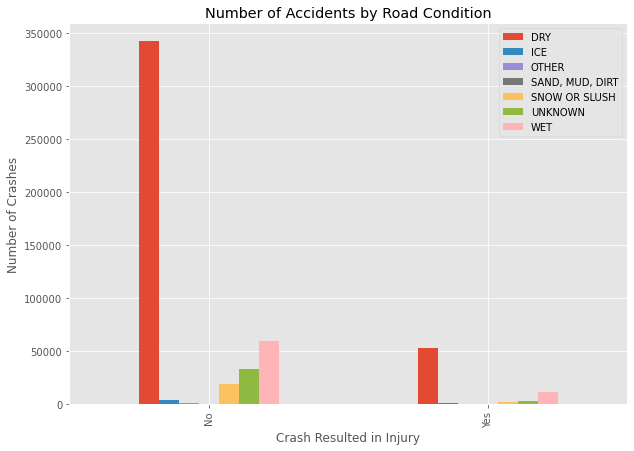

In [34]:
injury_vs_no_injury_plot(
    df_crashes, "roadway_surface_cond", 
    title="Number of Accidents by Road Condition",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

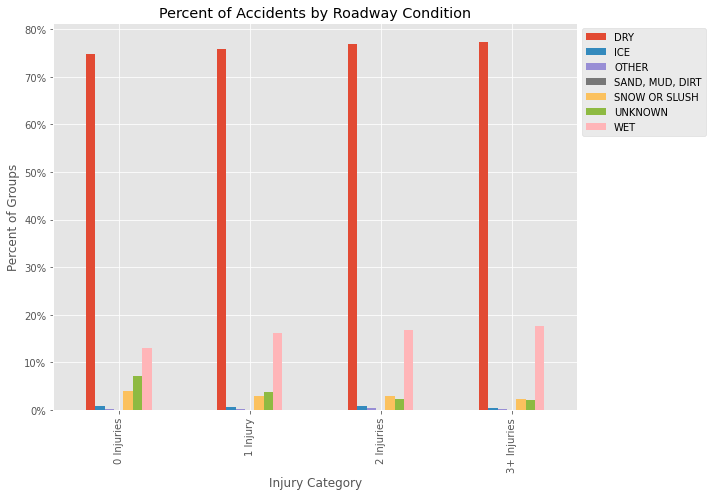

In [58]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "roadway_surface_cond",
    base_feature="injury_category",
    title="Percent of Accidents by Roadway Condition",
    xlabel="Injury Category",
    ylabel="Percent of Groups",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.8, num_points=9)
save_plot("percent-accidents-roadway-condition");

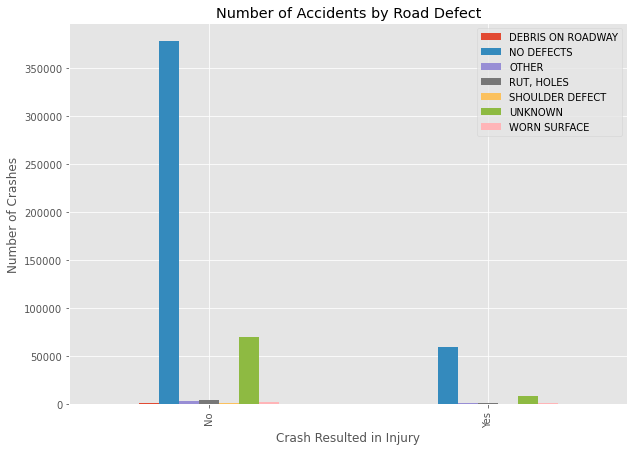

In [36]:
injury_vs_no_injury_plot(
    df_crashes, "road_defect", 
    title="Number of Accidents by Road Defect",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

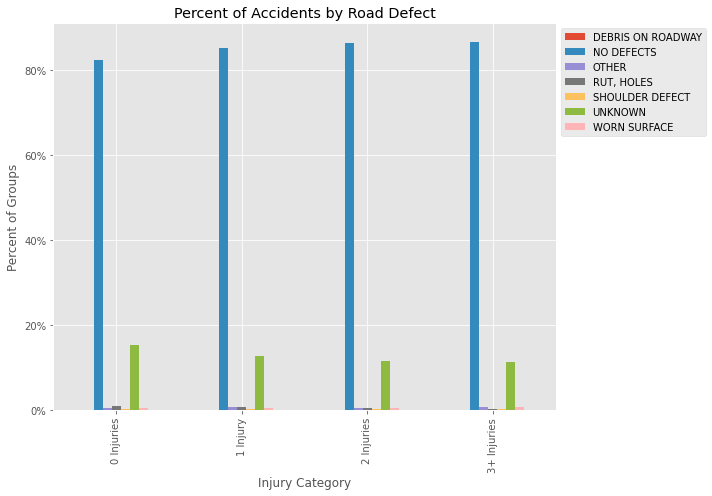

In [59]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "road_defect",
    base_feature="injury_category",
    title="Percent of Accidents by Road Defect",
    xlabel="Injury Category",
    ylabel="Percent of Groups",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.8, num_points=5)
save_plot("percent-accidents-by-road-defect");

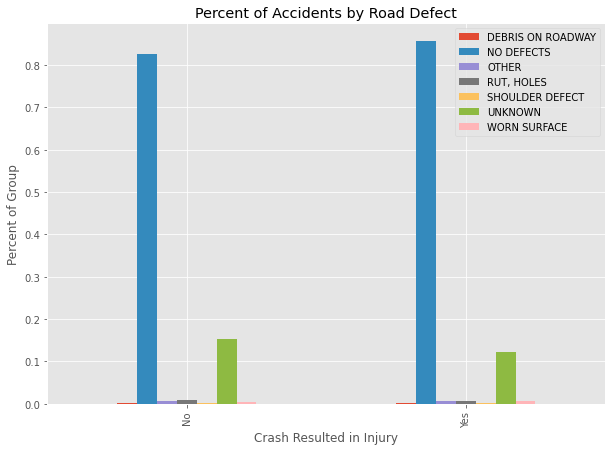

In [38]:
injury_vs_no_injury_plot(
    df_crashes, "road_defect", 
    title="Percent of Accidents by Road Defect",
    xlabel="Crash Resulted in Injury",
    ylabel="Percent of Group",
    percents=True);

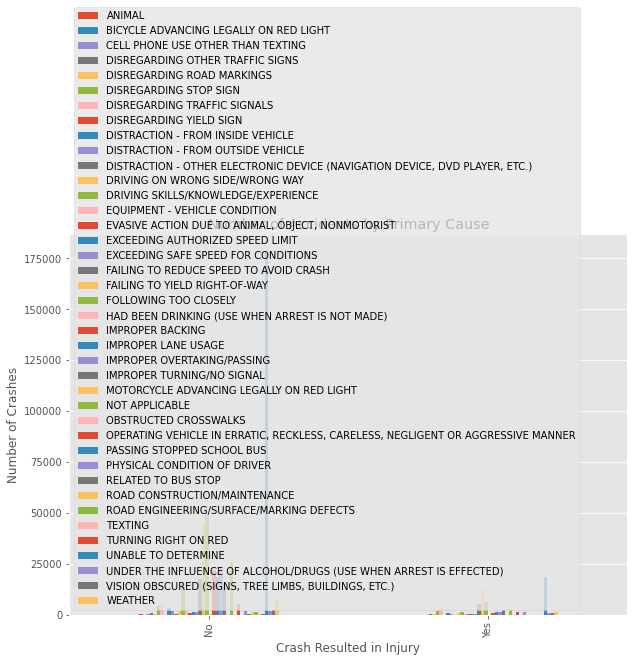

In [39]:
injury_vs_no_injury_plot(
    df_crashes, "prim_contributory_cause", 
    title="Number of Accidents by Primary Cause",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

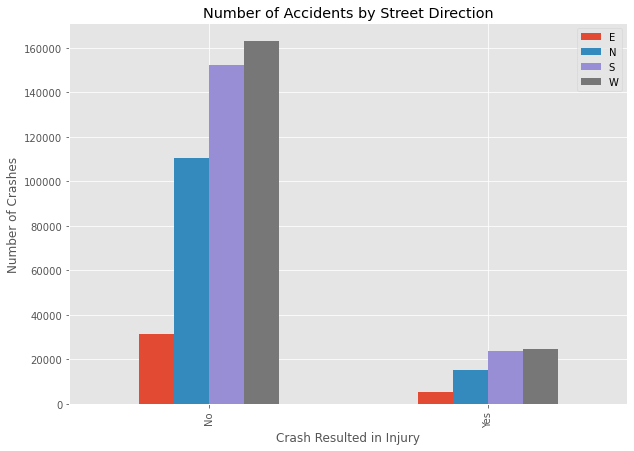

In [40]:
injury_vs_no_injury_plot(
    df_crashes, "street_direction", 
    title="Number of Accidents by Street Direction",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

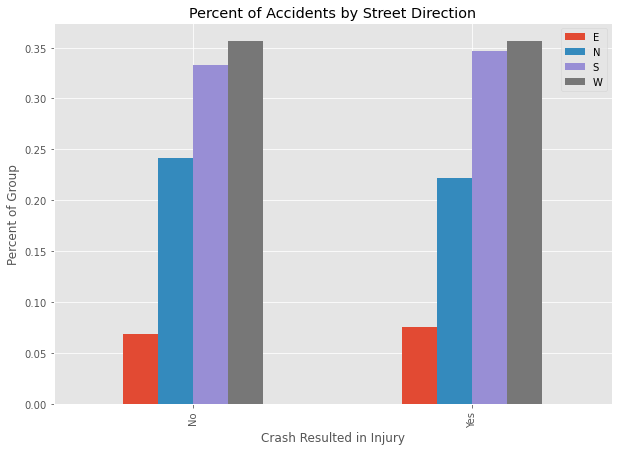

In [41]:
injury_vs_no_injury_plot(
    df_crashes, "street_direction", 
    title="Percent of Accidents by Street Direction",
    xlabel="Crash Resulted in Injury",
    ylabel="Percent of Group",
    percents=True);

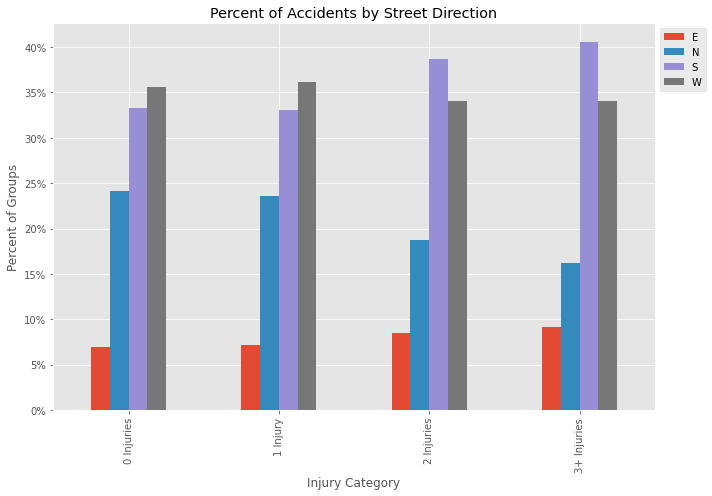

In [60]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "street_direction",
    base_feature="injury_category",
    title="Percent of Accidents by Street Direction",
    xlabel="Injury Category",
    ylabel="Percent of Groups",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.4, num_points=9)
save_plot("percent-accidents-by-street-direction");

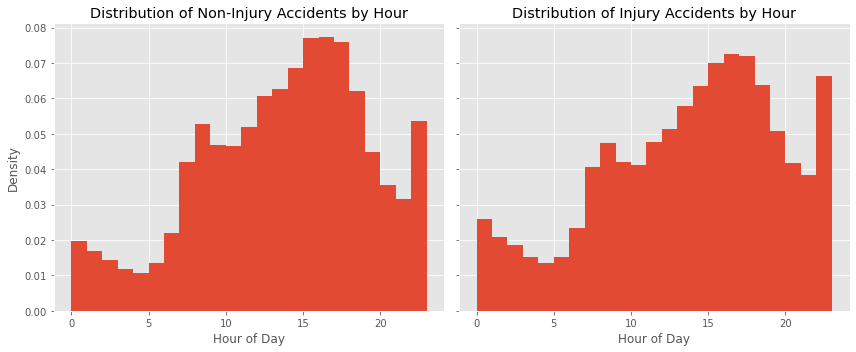

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
df_crashes.loc[df_crashes["has_injuries"]==False, "crash_hour"].plot(kind="hist", bins=23, ax=ax[0], density=True)
df_crashes.loc[df_crashes["has_injuries"]==True, "crash_hour"].plot(kind="hist", bins=23, ax=ax[1], density=True)
ax[0].title.set_text("Distribution of Non-Injury Accidents by Hour")
ax[1].title.set_text("Distribution of Injury Accidents by Hour")
ax[0].set_xlabel("Hour of Day")
ax[1].set_xlabel("Hour of Day")
ax[0].set_ylabel("Density")
fig.tight_layout()
save_plot("histogram-accidents-by-hour");

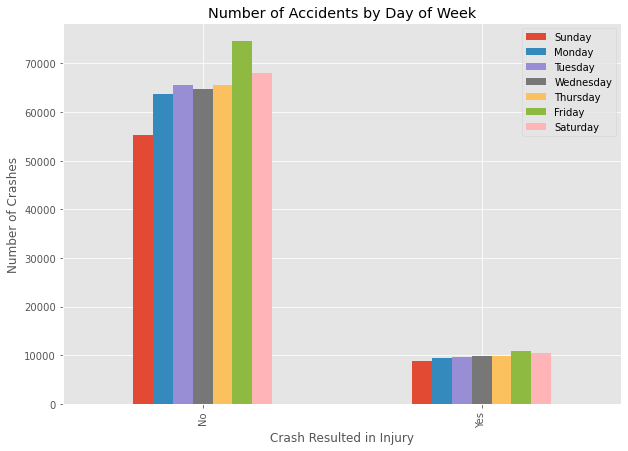

In [44]:
injury_vs_no_injury_plot(
    df_crashes, "crash_day_of_week", 
    title="Number of Accidents by Day of Week",
    xlabel="Crash Resulted in Injury",
    ylabel="Number of Crashes");

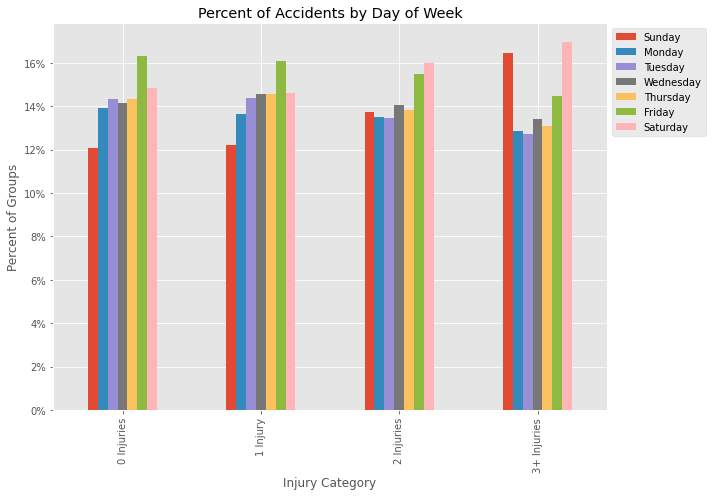

In [62]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "crash_day_of_week",
    base_feature="injury_category",
    title="Percent of Accidents by Day of Week",
    xlabel="Injury Category",
    ylabel="Percent of Groups",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.16, num_points=9)
save_plot("percent-accidents-day-of-week");

In [46]:
(df_crashes.groupby(["has_injuries", "crash_day_of_week"])["crash_record_id"]
        .count())

has_injuries  crash_day_of_week
False         Sunday               55281
              Monday               63681
              Tuesday              65675
              Wednesday            64825
              Thursday             65640
              Friday               74542
              Saturday             68001
True          Sunday                8829
              Monday                9351
              Tuesday               9703
              Wednesday             9904
              Thursday              9860
              Friday               10917
              Saturday             10360
Name: crash_record_id, dtype: int64

In [47]:
(df_crashes.groupby(["has_injuries"])["crash_record_id"]
        .count())

has_injuries
False    457645
True      68924
Name: crash_record_id, dtype: int64

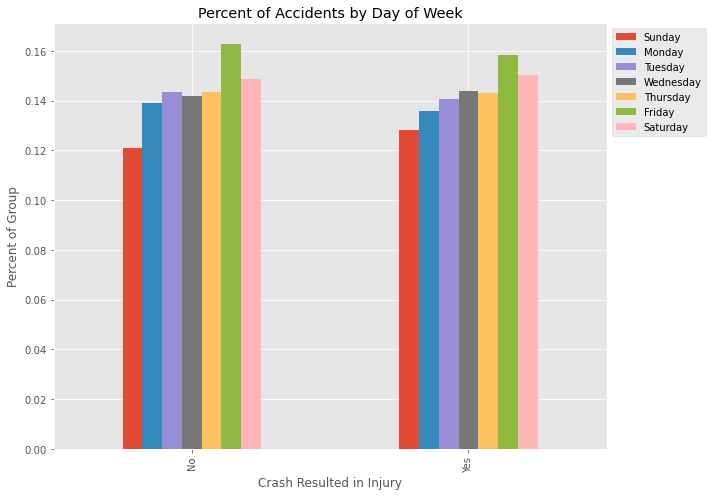

In [48]:
fig, ax = plt.subplots(figsize=(10, 7))
perc_crashes_day = ((df_crashes
    .groupby(["has_injuries", "crash_day_of_week"])["crash_record_id"].count()) 
    / (df_crashes.groupby(["has_injuries"])["crash_record_id"].count()))
(perc_crashes_day
    .reset_index()
    .set_index("has_injuries")
    .pivot(columns="crash_day_of_week", values="crash_record_id")
    .fillna(0.0)).plot(kind="bar", ax=ax)
ax.legend(title=None, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title("Percent of Accidents by Day of Week")
ax.set_xlabel("Crash Resulted in Injury")
ax.set_ylabel("Percent of Group")
ax.set_xticklabels(["No", "Yes"])
fig.tight_layout();

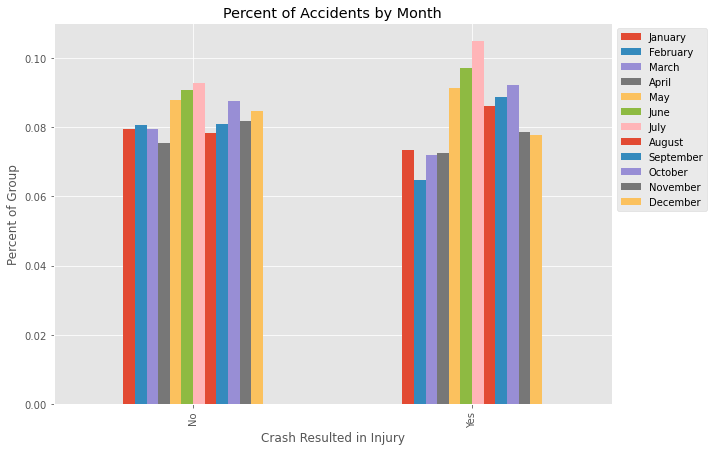

In [49]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "crash_month", 
    title="Percent of Accidents by Month",
    xlabel="Crash Resulted in Injury",
    ylabel="Percent of Group",
    percents=True)
ax.legend(title=None, loc="upper left", bbox_to_anchor=(1, 1));

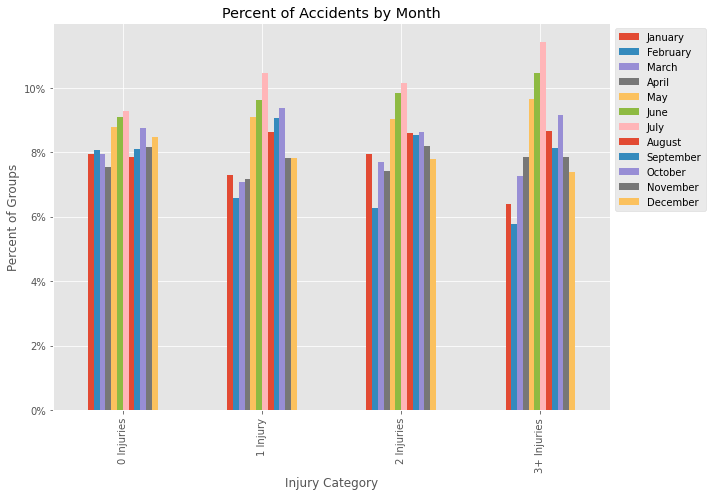

In [63]:
fig, ax = injury_vs_no_injury_plot(
    df_crashes, "crash_month",
    base_feature="injury_category",
    title="Percent of Accidents by Month",
    xlabel="Injury Category",
    ylabel="Percent of Groups",
    percents=True)
fig, ax = rewrite_yaxis_labels(fig, ax, percent=True, start=0.0, stop=0.1, num_points=6)
save_plot("percent-accidents-by-month");

In [51]:
# fig, ax = injury_vs_no_injury_plot(
#     df_crashes, "hit_and_run_i", 
#     title="Number of Accidents by Hit and Run",
#     xlabel="Crash Resulted in Injury",
#     ylabel="Percent of Group",
#     percents=True)

In [52]:
df_crashes.head()

,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,report_type,prim_contributory_cause,street_direction,num_units,injuries_total,crash_hour,crash_day_of_week,crash_month,intersection_related_i,hit_and_run_i,lane_cnt,has_injuries,injury_category
0,7a63945a9bae12c05dee82c1962bf40f23cdd02ca655d7...,2021-08-01 03:42:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,UNKNOWN,ON SCENE,DISREGARDING OTHER TRAFFIC SIGNS,S,2,0.0,3,Sunday,August,None,None,NaN,False,0 Injuries
1,d207ce72f4348fa06dddcd98628d0dec81d4f195cb8d8b...,2021-08-01 02:41:00,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),DISREGARDING TRAFFIC SIGNALS,N,2,1.0,2,Sunday,August,Y,Y,NaN,True,1 Injury
2,bba4db7cfef29230aa5d24f6b8912a2539b5d6f481a94e...,2021-08-01 02:26:00,25,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,UNKNOWN,ON SCENE,IMPROPER TURNING/NO SIGNAL,S,2,0.0,2,Sunday,August,None,None,NaN,False,0 Injuries
3,1e39110c6e01fd2f24e282cd610eb90d6f98a6241ab193...,2021-08-01 02:22:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,OTHER,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,UNABLE TO DETERMINE,S,2,1.0,2,Sunday,August,N,Y,NaN,True,1 Injury
4,d20d9db8a88fc227d48392b45380ae57898e5fcdcda7db...,2021-08-01 02:08:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DUSK,PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,IMPROPER LANE USAGE,W,3,2.0,2,Sunday,August,None,Y,NaN,True,2 Injuries


In [53]:
groups = [[23,135,3], [123,500,1]]
group_labels = ['views', 'orders']

# Convert data to pandas DataFrame.
df = pd.DataFrame(groups, index=group_labels).T
df

,views,orders
0,23,123
1,135,500
2,3,1


In [54]:
pd.concat(
    [df.mean().rename('average'), df.min().rename('min'), 
     df.max().rename('max')],
    axis=1)

,average,min,max
views,53.666667,3,135
orders,208.000000,1,500


<AxesSubplot:>

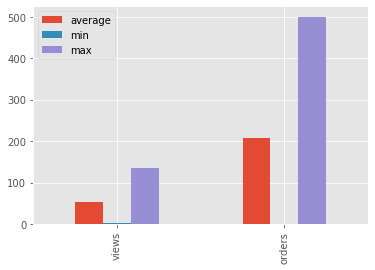

In [55]:
pd.concat(
    [df.mean().rename('average'), df.min().rename('min'), 
     df.max().rename('max')],
    axis=1).plot.bar()